<a href="https://colab.research.google.com/github/TLG442/Research_Project/blob/feature%2Felectricity-consumption-prediction-model%2Fit21222740/CNN_LSTM_GRU_pp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



 ## 2.Load Kaggle Dataset

In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
pythonafroz_electricity_smart_meter_data_from_india_path = kagglehub.dataset_download('pythonafroz/electricity-smart-meter-data-from-india')

print('Data source import complete.')


100%|██████████| 176M/176M [00:01<00:00, 96.0MB/s]

Extracting files...


Data source import complete.


## 3. Load and Preprocess Data

In [3]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np


dataset_path = pythonafroz_electricity_smart_meter_data_from_india_path

# Load the CSV files
df_2020 = pd.read_csv(os.path.join(dataset_path, "CEEW - Smart meter data Bareilly 2020.csv"))
df_2021 = pd.read_csv(os.path.join(dataset_path, "CEEW - Smart meter data Bareilly 2021.csv"))

# Combine data
df = pd.concat([df_2020, df_2021], axis=0, ignore_index=True)

### Sample Data and Timestamp Conversion

In [4]:
fraction = 0.1
df = df.sample(frac=fraction, random_state=42).reset_index(drop=True)
df['x_Timestamp'] = pd.to_datetime(df['x_Timestamp'])
df = df.sort_values('x_Timestamp')
df.set_index('x_Timestamp', inplace=True)


In [18]:
print(df.head())

             t_kWh  z_Avg Voltage (Volt)  z_Avg Current (Amp)
x_Timestamp                                                  
2020-01-01   0.001                257.14                 0.13
2020-01-01   0.008                249.10                 1.35
2020-01-01   0.002                251.26                 0.15
2020-01-01   0.000                250.75                 0.00
2020-01-01   0.005                253.89                 0.41


In [19]:
df.shape

(1057632, 3)




### Feature Selection and Missing Value Handling

In [5]:

# Drop unnecessary columns for prediction
df = df.drop(columns=['meter', 'y_Freq (Hz)'])  # Keep only relevant features

# Fill missing values if any (you can also try other imputation methods)
df = df.fillna(method='ffill')

<ipython-input-5-acf8ec1652a7>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


### Scale the data

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)



### Create sequences for the GRU model

In [8]:
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        xs.append(data[i:i+sequence_length])
        ys.append(data[i+sequence_length, 0])
    return np.array(xs), np.array(ys)


### Train-Test Split

In [9]:
# Sequence length for time steps (e.g., 60 minutes/steps)
sequence_length = 60

# Split the scaled data into training and test datasets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Create sequences
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape the data for GRU input (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Print the shape of the data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (846045, 60, 3), y_train shape: (846045,)
X_test shape: (211467, 60, 3), y_test shape: (211467,)


## Model Architecture

In [11]:
from keras.models import Sequential
from keras.layers import GRU, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build a combined model with GRU, LSTM, and CNN
model = Sequential()

# 1D Convolutional Layer to extract local features
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Add an LSTM layer to capture long-term dependencies
model.add(LSTM(units=100, return_sequences=True))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Add a GRU layer to capture short-term dependencies
model.add(GRU(units=100, return_sequences=False))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Fully connected layer to combine features learned from previous layers
model.add(Dense(units=100))
model.add(Activation('relu'))

# Dropout layer to prevent overfitting
model.add(Dropout(0.3))

# Output layer for regression (predicting 't_kWh')
model.add(Dense(units=1))

model.summary()




/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 58, 64)              │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 29, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 29, 100)             │          66,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 29, 100)             │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 29, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 100)                 │          60,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,497 (541.00 KB)

 Trainable params: 137,969 (538.94 KB)

 Non-trainable params: 528 (2.06 KB)

## Training Process

In [12]:
# Compile the model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae', 'mse'])

# Callbacks for early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/5
13220/13220 ━━━━━━━━━━━━━━━━━━━━ 165s 12ms/step - loss: 0.0099 - mae: 0.0553 - mse: 0.0099 - val_loss: 0.0102 - val_mae: 0.0617 - val_mse: 0.0102 - learning_rate: 0.0010
Epoch 2/5
13220/13220 ━━━━━━━━━━━━━━━━━━━━ 188s 11ms/step - loss: 0.0059 - mae: 0.0472 - mse: 0.0059 - val_loss: 0.0100 - val_mae: 0.0665 - val_mse: 0.0100 - learning_rate: 0.0010
Epoch 3/5
13220/13220 ━━━━━━━━━━━━━━━━━━━━ 202s 11ms/step - loss: 0.0059 - mae: 0.0469 - mse: 0.0059 - val_loss: 0.0100 - val_mae: 0.0632 - val_mse: 0.0100 - learning_rate: 0.0010
Epoch 4/5
13220/13220 ━━━━━━━━━━━━━━━━━━━━ 149s 11ms/step - loss: 0.0059 - mae: 0.0467 - mse: 0.0059 - val_loss: 0.0101 - val_mae: 0.0622 - val_mse: 0.0101 - learning_rate: 0.0010
Epoch 5/5
13220/13220 ━━━━━━━━━━━━━━━━━━━━ 214s 12ms/step - loss: 0.0059 - mae: 0.0468 - mse: 0.0059 - val_loss: 0.0100 - val_mae: 0.0636 - val_mse: 0.0100 - learning_rate: 0.0010


## Evaluate the model on the test data

In [13]:
# Evaluate the model on the test data
test_loss, test_mae, test_mse = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")
print(f"Test MSE: {test_mse}")


6609/6609 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.0092 - mae: 0.0634 - mse: 0.0092
Test Loss: 0.009970293380320072
Test MAE: 0.06645897775888443
Test MSE: 0.009970293380320072


6609/6609 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


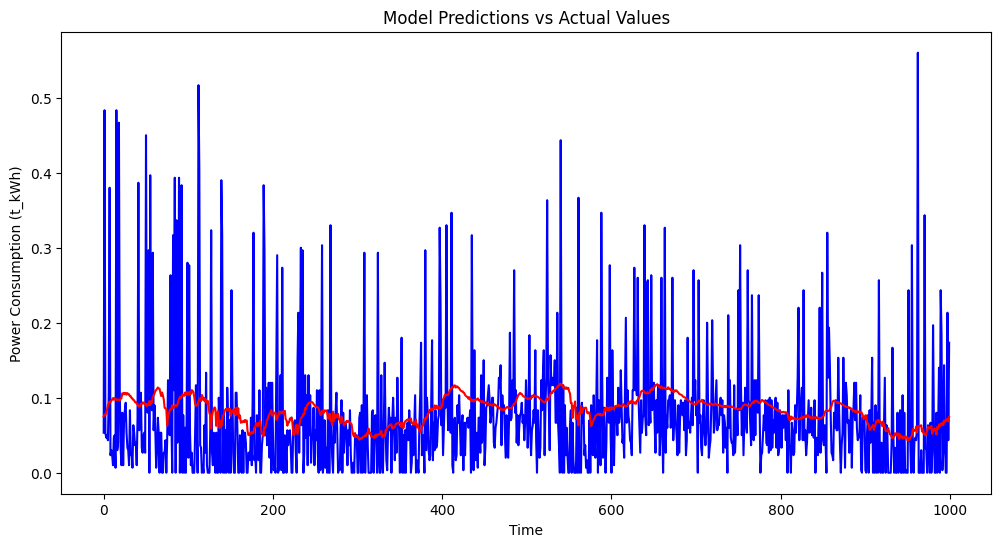

In [14]:
# Predict on the test set
y_pred = model.predict(X_test)

# Visualize the predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test[:1000], label='Actual', color='blue')
plt.plot(y_pred[:1000], label='Predicted', color='red')
plt.title('Model Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Power Consumption (t_kWh)')
plt.show()


In [15]:
# Save the GRU model to a file
model.save('smart_meter_conv_lstm_gru_model.h5')
